A/B Test Result Analysis (Toca Boca: Part 2)
===

## Objective
Analyse the results of the A/B test for a new feature and provide recommendations for which variant the game should go
with and why.

## Approach
* **Exploratory Data Analysis (EDA):** Explored the results to understand the distribution and key characteristics of the control and treatment groups' revenue data.

* **Hypothesis Testing:** Performed an independent samples t-test to compare the means of the control and treatment groups, determining the statistical significance of the observed differences in revenue.

* **Effect Size and Confidence Intervals:** Calculated Cohen's d to measure the magnitude of the difference and computed 95% confidence intervals to estimate the range of the true mean differences, providing insights into the practical significance.

## Key Findings
From these results I determined that although the new feature introduced to group B did influence more users to convert, the impact was very small which implies that although introducing the new feature will make a difference in increasing revenue, it may not make practical sense to do so. 

## Next Steps

- **Consider the business context:** A very small increase in revenue might not justify the costs or efforts of implementing the new feature.
- **Look at other metrics:** It would be good to consider other metrics (e.g., user engagement, satisfaction) to get a more comprehensive view of the feature's impact.
- **Segment Analysis:** It might be a good idea to segment the users to see if the effect is more pronounced in certain user groups.

# 1. Import

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

In [8]:
results_df = pd.read_csv("./ab_test.csv")

In [12]:
results_df.head()

,id,variant,dt,spend_usd
0,1,A,2020-01-01,0.0
1,2,A,2020-01-01,0.0
2,3,A,2020-01-01,0.0
3,4,A,2020-01-01,0.0
4,5,A,2020-01-01,0.0


# 2. Pre-process

In [17]:
def check_data(df):
    # Generates a concise summary of DataFrame columns.
    
    # We use list comprehension to iterate over each column
    summary = [
        [col, df[col].dtype, df[col].count(), df[col].nunique(), df[col].isnull().sum(), df.duplicated().sum()]
        for col in df.columns
    ]
    # Create a DataFrame from the list of lists
    df_check = pd.DataFrame(summary, columns=["column", "dtype", "instances", "unique", "sum_null", "duplicates"])

    return df_check

# 3. Analyse

## 3.1 EDA

In [52]:
results_df.head()

,id,variant,dt,spend_usd
0,1,A,2020-01-01,0.0
1,2,A,2020-01-01,0.0
2,3,A,2020-01-01,0.0
3,4,A,2020-01-01,0.0
4,5,A,2020-01-01,0.0


In [59]:
for variant in results_df['variant'].unique().tolist():
    print(f"Checking data for variant {variant}")
    print(check_data(results_df[results_df['variant'] == variant]))
    print("\n")

Checking data for variant A
      column    dtype  instances  unique  sum_null  duplicates
0         id    int64    2100000  100000         0           0
1    variant   object    2100000       1         0           0
2         dt   object    2100000      21         0           0
3  spend_usd  float64    2100000  261255         0           0


Checking data for variant B
      column    dtype  instances  unique  sum_null  duplicates
0         id    int64    2100000  100000         0           0
1    variant   object    2100000       1         0           0
2         dt   object    2100000      21         0           0
3  spend_usd  float64    2100000  251214         0           0




In [51]:
results_df.groupby(by='variant')['spend_usd'].describe()

,count,mean,std,min,25%,50%,75%,max
variant,,,,,,,,
A,2100000.0,1.498369,3.590117,0.0,0.0,0.0,0.0,14.58588
B,2100000.0,1.678660,4.036659,0.0,0.0,0.0,0.0,16.85948


In [68]:
results_df.groupby(by='variant')['spend_usd'].sum()

variant
A    3.146574e+06
B    3.525187e+06
Name: spend_usd, dtype: float64

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


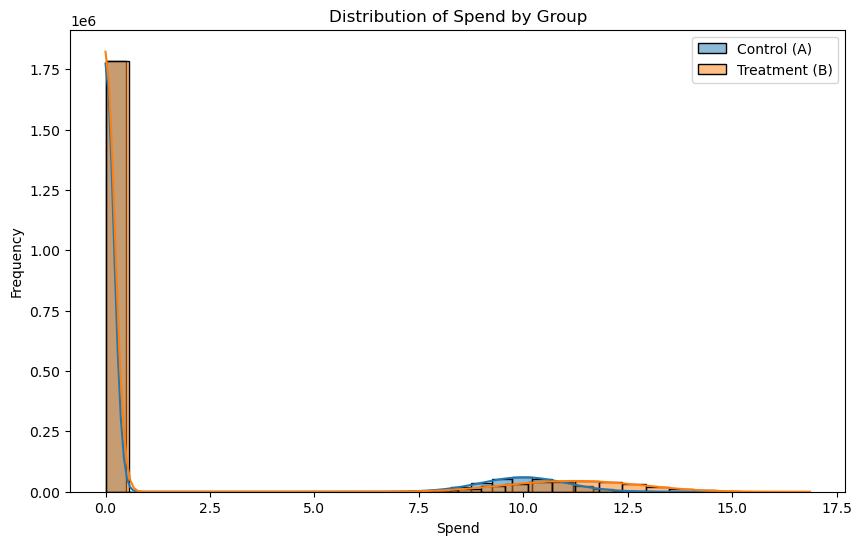

In [60]:
# Separate control and treatment groups
control = results_df[results_df['variant'] == 'A']
treatment = results_df[results_df['variant'] == 'B']

# Plot histograms with KDE
plt.figure(figsize=(10, 6))
sns.histplot(control['spend_usd'], bins=30, kde=True, label='Control (A)', alpha=0.5)
sns.histplot(treatment['spend_usd'], bins=30, kde=True, label='Treatment (B)', alpha=0.5)
plt.xlabel('Spend')
plt.ylabel('Frequency')
plt.title('Distribution of Spend by Group')
plt.legend(loc='upper right')
plt.show()

**Observations**
* The results are heavily skewed to the left, meaning most users involved in this experiment didn't make any purchases.
* Since it is hard to tell much more from this graph, it may be good to visualize the histrograms by first excluding users who never converted

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


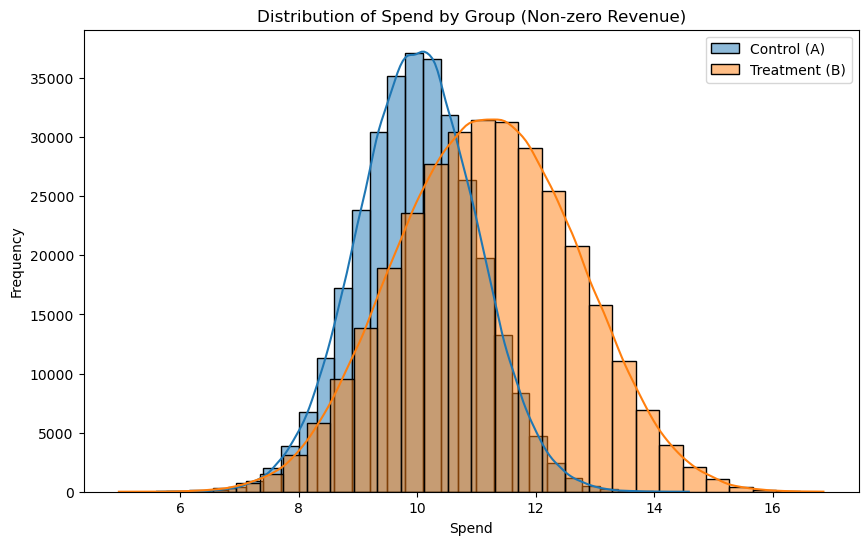

In [75]:
# Separate control and treatment groups
control_non_zero = control[control['spend_usd'] > 0]
treatment_non_zero = treatment[treatment['spend_usd'] > 0]

# Plot histograms with KDE
plt.figure(figsize=(10, 6))
sns.histplot(control_non_zero['spend_usd'], bins=30, kde=True, label='Control (A)', alpha=0.5)
sns.histplot(treatment_non_zero['spend_usd'], bins=30, kde=True, label='Treatment (B)', alpha=0.5)
plt.xlabel('Spend')
plt.ylabel('Frequency')
plt.title("Distribution of Spend by Group (Non-zero Revenue)")
plt.legend(loc='upper right')
plt.show()

**Observations:** In this visualization we can see more clearly that there is a difference between the means of the two groups

In [46]:
results_df.groupby(by='variant')['spend_usd'].agg(['mean', 'median', 'std']).transpose()

variant,A,B
mean,1.498369,1.678660
median,0.000000,0.000000
std,3.590117,4.036659


## 3.2 Hypothesis Testing 

In [32]:
t_stat, p_val = stats.ttest_ind(control['spend_usd'], treatment['spend_usd'])
print(f'T-statistic: {t_stat}, P-value: {p_val}')

T-statistic: -48.36333891176516, P-value: 0.0


**Observations:**

- T-statistic: The large negative t-statistic (-48.36) suggests a significant difference between the means of the control and treatment groups. The negative sign simply indictes that the mean of the control group is lower than that of the treatment group.
- P-value: Since this value is so low (0.0) it means that the observed difference is extremely unlikely to have occurred by chance.

Overall, we can determine that the results statistically significant, which means the difference between the two groups didn't happen by chance, but instead we can confidently assume, the feature changes had an effect in the behavior of the users.

## 3.3 Effect Size and Confidence Intervals

### Effect Size

In [66]:
# Calculate the pooled standard deviation
control_std = control['spend_usd'].std()
treatment_std = treatment['spend_usd'].std()
pooled_std = np.sqrt((control_std**2 + treatment_std**2) / 2)

# Calculate the effect size
effect_size = (treatment['spend_usd'].mean() - control['spend_usd'].mean()) / pooled_std
print(f'Effect Size (Cohen\'s d): {effect_size}')

Effect Size (Cohen's d): 0.047197785971348674


In [67]:
# Interpretation of Cohen's d
if abs(effect_size) < 0.2:
    print("Effect size is very small or negligible")
elif abs(effect_size) < 0.5:
    print("Effect size is small")
elif abs(effect_size) < 0.8:
    print("Effect size is medium")
else:
    print("Effect size is large")

Effect size is very small or negligible


**Observations:** The effect size (Cohen's d) is very small or negligible (0.04) which suggests that while the difference is statistically significant, the magnitude of the difference is very small. In practical terms, the new feature has a negligible impact on revenue.

### Confidence Intervals

In [69]:
# Confidence intervals for control group
conf_int_control = stats.t.interval(0.95, len(control)-1, loc=np.mean(control['spend_usd']), scale=stats.sem(control['spend_usd']))
print(f'95% Confidence Interval for Control Group: {conf_int_control}')

# Confidence intervals for treatment group
conf_int_treatment = stats.t.interval(0.95, len(treatment)-1, loc=np.mean(treatment['spend_usd']), scale=stats.sem(treatment['spend_usd']))
print(f'95% Confidence Interval for Treatment Group: {conf_int_treatment}')

95% Confidence Interval for Control Group: (1.4935130721375702, 1.5032243714699072)
95% Confidence Interval for Treatment Group: (1.6732008287915086, 1.6841200268070178)


**Observations:** The fact that the confidence intervals for the control and treatment groups do not overlap indicates that there is a statistically significant difference between the mean revenues of the two groups.

## 3.4 Results and Conclusion

From these results we can determine that although the new feature introduced to group B did influence more users to convert, the impact was very small which implies that although introducing the new feature will make a difference in increasing revenue, it may not make practical sense to do so. 

**Potential Next Steps:**
- Consider the business context: A very small increase in revenue might not justify the costs or efforts of implementing the new feature.
- Look at other metrics: It would be good to consider other metrics (e.g., user engagement, satisfaction) to get a more comprehensive view of the feature's impact.
- Segment Analysis: Perform segmentation analysis to see if the effect is more pronounced in certain user groups.